In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

### load mnist dataset

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100)

label: 5


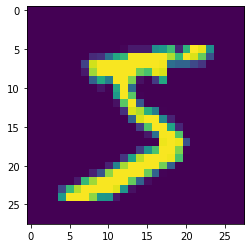

In [ ]:
import matplotlib.pyplot as plt

print("label:", train_data[0][1])
plt.imshow(train_data[0][0].permute(1, 2, 0))
plt.show()

### describe classifier by means of pytorch

In [ ]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super(MnistClassifier, self).__init__()
        # input : 1 x 28 x 28
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 24, 5, stride=1, padding=2), # preserve img shape
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # div 2
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(24, 48, 5, stride=1, padding=2), # preserve img shape
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # div 2
        )
        self.fc = nn.Linear(7 * 7 * 48, 10) # input : 48 x 7 x 7
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


### mnist, numbers

In [ ]:
def train_model(model, criterion, optimizer, train_loader, scheduler=None, epoches=6):
    loss_list = []
    acc_list = []
    for epoch in range(epoches):
        for i, (images, labels) in enumerate(train_loader):
            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # metrics
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, epoches, i + 1, len(train_loader), loss.item(),
                            (correct / total) * 100))
        if scheduler is not None:
                scheduler.step()
    
    return loss_list, acc_list

In [ ]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the {} test images: {} %'
            .format(total, (correct / total) * 100))

In [ ]:
model = MnistClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

loss_list, acc_list = train_model(model, criterion, optimizer, train_loader)
test_model(model, test_loader)

Epoch [1/6], Step [100/600], Loss: 2.2961, Accuracy: 16.00%
Epoch [1/6], Step [200/600], Loss: 2.2779, Accuracy: 39.00%
Epoch [1/6], Step [300/600], Loss: 2.2766, Accuracy: 29.00%
Epoch [1/6], Step [400/600], Loss: 2.2649, Accuracy: 27.00%
Epoch [1/6], Step [500/600], Loss: 2.2516, Accuracy: 45.00%
Epoch [1/6], Step [600/600], Loss: 2.2323, Accuracy: 47.00%
Epoch [2/6], Step [100/600], Loss: 2.2105, Accuracy: 51.00%
Epoch [2/6], Step [200/600], Loss: 2.2037, Accuracy: 47.00%
Epoch [2/6], Step [300/600], Loss: 2.1550, Accuracy: 54.00%
Epoch [2/6], Step [400/600], Loss: 2.1285, Accuracy: 60.00%
Epoch [2/6], Step [500/600], Loss: 2.0942, Accuracy: 65.00%
Epoch [2/6], Step [600/600], Loss: 2.0433, Accuracy: 73.00%
Epoch [3/6], Step [100/600], Loss: 1.9929, Accuracy: 63.00%
Epoch [3/6], Step [200/600], Loss: 1.9211, Accuracy: 73.00%
Epoch [3/6], Step [300/600], Loss: 1.7700, Accuracy: 84.00%
Epoch [3/6], Step [400/600], Loss: 1.6746, Accuracy: 80.00%
Epoch [3/6], Step [500/600], Loss: 1.420

model analysis

In [ ]:
import pandas as pd

def plot_smoothed_series(series, title, n=100):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(15,5))
    plt.title("Moving average for {}\n window size = {}".format(title, n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.legend()
    plt.grid(True)

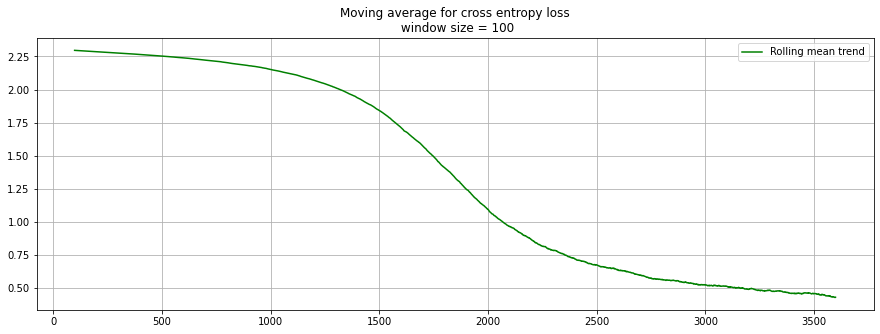

In [ ]:
plot_smoothed_series(pd.Series(loss_list), "cross entropy loss")

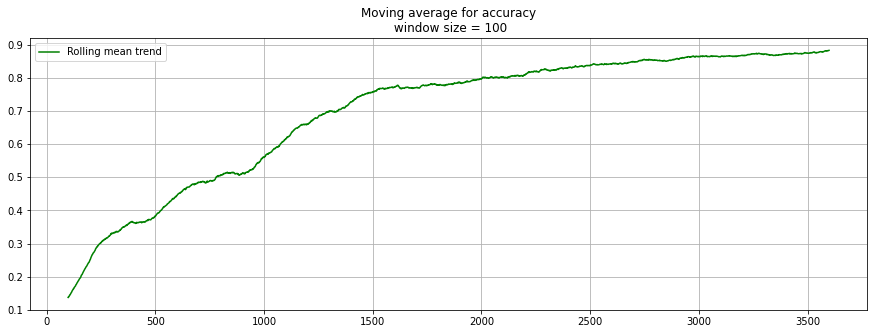

In [ ]:
plot_smoothed_series(pd.Series(acc_list), "accuracy")

### params

In [ ]:
numbers_mnist_classifier_params = model.state_dict()

In [ ]:
from torchsummary import summary

summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
              ReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 14, 14]          28,848
              ReLU-5           [-1, 48, 14, 14]               0
         MaxPool2d-6             [-1, 48, 7, 7]               0
            Linear-7                   [-1, 10]          23,530
Total params: 53,002
Trainable params: 53,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.20
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


### fashon mnist classification (no transfer learning, same arch)

In [ ]:
fashion_train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
fashion_test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

fashion_train_loader = DataLoader(dataset=fashion_train_data, batch_size=100, shuffle=True)
fashion_test_loader = DataLoader(dataset=fashion_test_data, batch_size=100)

label: 9


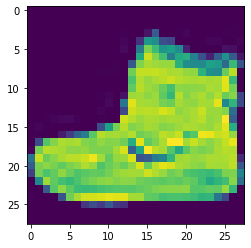

In [ ]:
print("label:", fashion_train_data[0][1])
plt.imshow(fashion_train_data[0][0].permute(1, 2, 0))
plt.show()

In [ ]:
from torch.optim import lr_scheduler

fashion_model = MnistClassifier()
fashion_criterion = nn.CrossEntropyLoss()
fashion_optimizer = optim.SGD(fashion_model.parameters(), lr=1e-3, momentum=0.9)
fashion_scheduler = lr_scheduler.StepLR(fashion_optimizer, step_size=3, gamma=0.1)

loss_list, acc_list = train_model(fashion_model, fashion_criterion, fashion_optimizer, fashion_train_loader, scheduler=fashion_scheduler)
test_model(fashion_model, fashion_test_loader)

Epoch [1/6], Step [100/600], Loss: 1.6341, Accuracy: 59.00%
Epoch [1/6], Step [200/600], Loss: 0.7403, Accuracy: 76.00%
Epoch [1/6], Step [300/600], Loss: 0.7179, Accuracy: 71.00%
Epoch [1/6], Step [400/600], Loss: 0.6698, Accuracy: 76.00%
Epoch [1/6], Step [500/600], Loss: 0.6424, Accuracy: 73.00%
Epoch [1/6], Step [600/600], Loss: 0.6037, Accuracy: 79.00%
Epoch [2/6], Step [100/600], Loss: 0.5591, Accuracy: 81.00%
Epoch [2/6], Step [200/600], Loss: 0.6046, Accuracy: 75.00%
Epoch [2/6], Step [300/600], Loss: 0.6169, Accuracy: 75.00%
Epoch [2/6], Step [400/600], Loss: 0.4986, Accuracy: 85.00%
Epoch [2/6], Step [500/600], Loss: 0.4322, Accuracy: 85.00%
Epoch [2/6], Step [600/600], Loss: 0.4620, Accuracy: 81.00%
Epoch [3/6], Step [100/600], Loss: 0.5462, Accuracy: 78.00%
Epoch [3/6], Step [200/600], Loss: 0.7605, Accuracy: 72.00%
Epoch [3/6], Step [300/600], Loss: 0.4520, Accuracy: 83.00%
Epoch [3/6], Step [400/600], Loss: 0.4539, Accuracy: 85.00%
Epoch [3/6], Step [500/600], Loss: 0.474

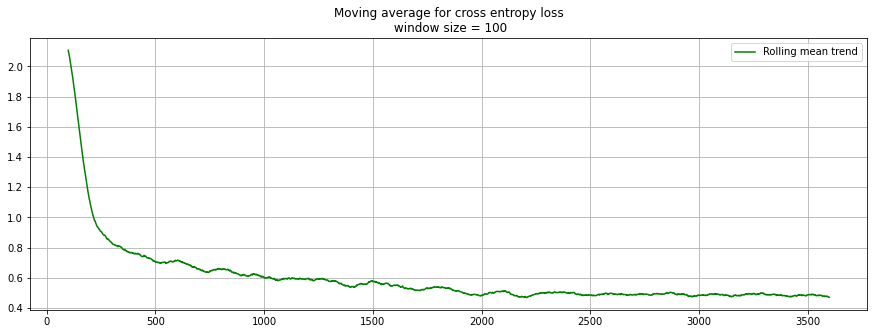

In [ ]:
plot_smoothed_series(pd.Series(loss_list), "cross entropy loss")

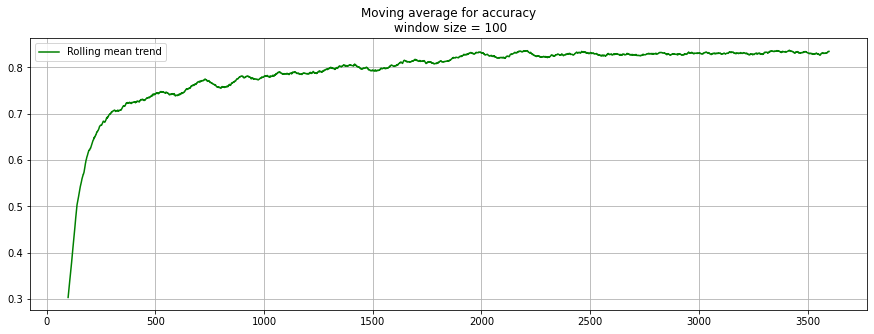

In [ ]:
plot_smoothed_series(pd.Series(acc_list), "accuracy")

### fashion mnist classification (start with pretrained params)

In [ ]:
fashion_model = MnistClassifier()
fashion_model.load_state_dict(numbers_mnist_classifier_params)
fashion_criterion = nn.CrossEntropyLoss()
fashion_optimizer = optim.SGD(fashion_model.parameters(), lr=1e-3, momentum=0.9)
fashion_scheduler = lr_scheduler.StepLR(fashion_optimizer, step_size=3, gamma=0.1)

loss_list2, acc_list2 = train_model(fashion_model, fashion_criterion, fashion_optimizer, fashion_train_loader, scheduler=fashion_scheduler)
test_model(fashion_model, fashion_test_loader)

Epoch [1/6], Step [100/600], Loss: 0.8982, Accuracy: 63.00%
Epoch [1/6], Step [200/600], Loss: 0.7274, Accuracy: 77.00%
Epoch [1/6], Step [300/600], Loss: 0.6525, Accuracy: 73.00%
Epoch [1/6], Step [400/600], Loss: 0.6593, Accuracy: 74.00%
Epoch [1/6], Step [500/600], Loss: 0.5012, Accuracy: 84.00%
Epoch [1/6], Step [600/600], Loss: 0.5292, Accuracy: 83.00%
Epoch [2/6], Step [100/600], Loss: 0.6273, Accuracy: 78.00%
Epoch [2/6], Step [200/600], Loss: 0.5776, Accuracy: 77.00%
Epoch [2/6], Step [300/600], Loss: 0.6285, Accuracy: 79.00%
Epoch [2/6], Step [400/600], Loss: 0.6140, Accuracy: 80.00%
Epoch [2/6], Step [500/600], Loss: 0.5266, Accuracy: 84.00%
Epoch [2/6], Step [600/600], Loss: 0.5383, Accuracy: 80.00%
Epoch [3/6], Step [100/600], Loss: 0.4604, Accuracy: 82.00%
Epoch [3/6], Step [200/600], Loss: 0.5751, Accuracy: 78.00%
Epoch [3/6], Step [300/600], Loss: 0.4827, Accuracy: 82.00%
Epoch [3/6], Step [400/600], Loss: 0.5658, Accuracy: 82.00%
Epoch [3/6], Step [500/600], Loss: 0.572

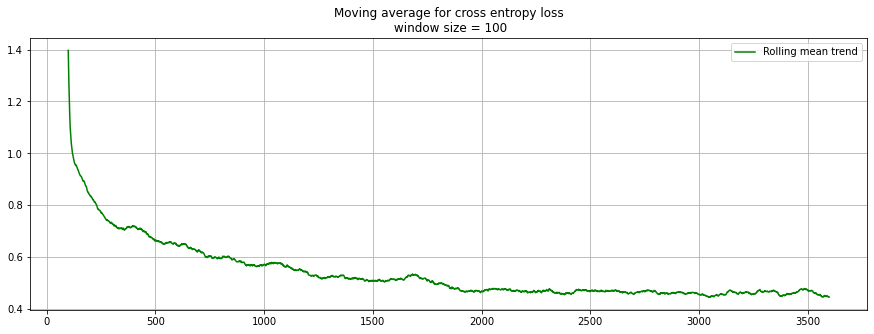

In [ ]:
plot_smoothed_series(pd.Series(loss_list2), "cross entropy loss")

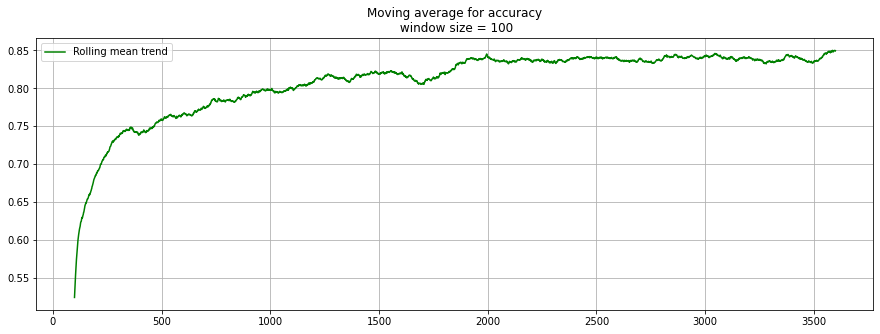

In [ ]:
plot_smoothed_series(pd.Series(acc_list2), "accuracy")

### fashion mnist classification (pretrained, frozen conv layers)

In [ ]:
for param_name, child in fashion_model.named_children():
    print(param_name)

conv1
conv2
fc


In [ ]:
fashion_model = MnistClassifier()
fashion_model.load_state_dict(numbers_mnist_classifier_params)
fashion_criterion = nn.CrossEntropyLoss()

for param_name, child in fashion_model.named_children():
    if param_name != "fc":
        child.requires_grad = False

fashion_optimizer = optim.SGD(filter(lambda x: x.requires_grad, fashion_model.parameters()), lr=1e-3, momentum=0.9)
fashion_scheduler = lr_scheduler.StepLR(fashion_optimizer, step_size=3, gamma=0.1)

loss_list3, acc_list3 = train_model(fashion_model, fashion_criterion, fashion_optimizer, fashion_train_loader, scheduler=fashion_scheduler)
test_model(fashion_model, fashion_test_loader)

Epoch [1/6], Step [100/600], Loss: 0.8802, Accuracy: 64.00%
Epoch [1/6], Step [200/600], Loss: 0.7993, Accuracy: 65.00%
Epoch [1/6], Step [300/600], Loss: 0.7484, Accuracy: 65.00%
Epoch [1/6], Step [400/600], Loss: 0.7268, Accuracy: 73.00%
Epoch [1/6], Step [500/600], Loss: 0.6267, Accuracy: 75.00%
Epoch [1/6], Step [600/600], Loss: 0.6614, Accuracy: 76.00%
Epoch [2/6], Step [100/600], Loss: 0.5381, Accuracy: 84.00%
Epoch [2/6], Step [200/600], Loss: 0.5659, Accuracy: 81.00%
Epoch [2/6], Step [300/600], Loss: 0.6464, Accuracy: 76.00%
Epoch [2/6], Step [400/600], Loss: 0.5914, Accuracy: 80.00%
Epoch [2/6], Step [500/600], Loss: 0.6255, Accuracy: 80.00%
Epoch [2/6], Step [600/600], Loss: 0.4527, Accuracy: 83.00%
Epoch [3/6], Step [100/600], Loss: 0.4714, Accuracy: 82.00%
Epoch [3/6], Step [200/600], Loss: 0.6234, Accuracy: 77.00%
Epoch [3/6], Step [300/600], Loss: 0.5612, Accuracy: 76.00%
Epoch [3/6], Step [400/600], Loss: 0.6174, Accuracy: 79.00%
Epoch [3/6], Step [500/600], Loss: 0.483

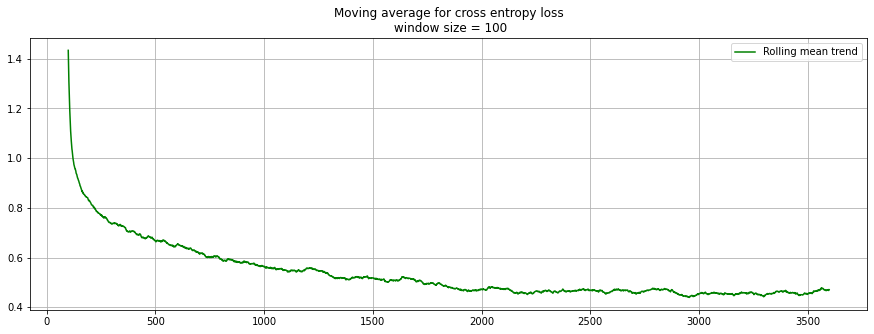

In [ ]:
plot_smoothed_series(pd.Series(loss_list3), "cross entropy loss")

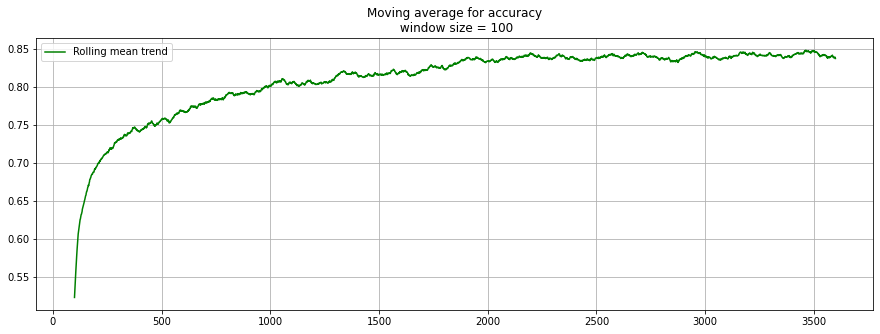

In [ ]:
plot_smoothed_series(pd.Series(acc_list3), "accuracy")

### fashino mnist classification (pretrained, frozen conv layers, unfreeze in the middle of training)

In [ ]:
fashion_model = MnistClassifier()
fashion_model.load_state_dict(numbers_mnist_classifier_params)
fashion_criterion = nn.CrossEntropyLoss()

for param_name, child in fashion_model.named_children():
    if param_name != "fc":
        child.requires_grad = False

fashion_optimizer = optim.SGD(filter(lambda x: x.requires_grad, fashion_model.parameters()), lr=1e-3, momentum=0.9)

loss_list4, acc_list4 = train_model(fashion_model, fashion_criterion, fashion_optimizer, fashion_train_loader, epoches=3)

for param_name, child in fashion_model.named_children():
    child.requires_grad = True

fashion_optimizer = optim.SGD(fashion_model.parameters(), lr=1e-4, momentum=0.9)

loss_list5, acc_list5 = train_model(fashion_model, fashion_criterion, fashion_optimizer, fashion_train_loader, epoches=3)
loss_list4 += loss_list5
acc_list4 += acc_list5

Epoch [1/3], Step [100/600], Loss: 0.7934, Accuracy: 72.00%
Epoch [1/3], Step [200/600], Loss: 0.7053, Accuracy: 69.00%
Epoch [1/3], Step [300/600], Loss: 0.7489, Accuracy: 74.00%
Epoch [1/3], Step [400/600], Loss: 0.5926, Accuracy: 82.00%
Epoch [1/3], Step [500/600], Loss: 0.5989, Accuracy: 79.00%
Epoch [1/3], Step [600/600], Loss: 0.6156, Accuracy: 82.00%
Epoch [2/3], Step [100/600], Loss: 0.5319, Accuracy: 83.00%
Epoch [2/3], Step [200/600], Loss: 0.4650, Accuracy: 82.00%
Epoch [2/3], Step [300/600], Loss: 0.5782, Accuracy: 83.00%
Epoch [2/3], Step [400/600], Loss: 0.4219, Accuracy: 85.00%
Epoch [2/3], Step [500/600], Loss: 0.5662, Accuracy: 76.00%
Epoch [2/3], Step [600/600], Loss: 0.5650, Accuracy: 76.00%
Epoch [3/3], Step [100/600], Loss: 0.5833, Accuracy: 79.00%
Epoch [3/3], Step [200/600], Loss: 0.5029, Accuracy: 83.00%
Epoch [3/3], Step [300/600], Loss: 0.5502, Accuracy: 81.00%
Epoch [3/3], Step [400/600], Loss: 0.4840, Accuracy: 87.00%
Epoch [3/3], Step [500/600], Loss: 0.460

In [ ]:
test_model(fashion_model, fashion_test_loader)

Accuracy of the model on the 10000 test images: 83.26 %


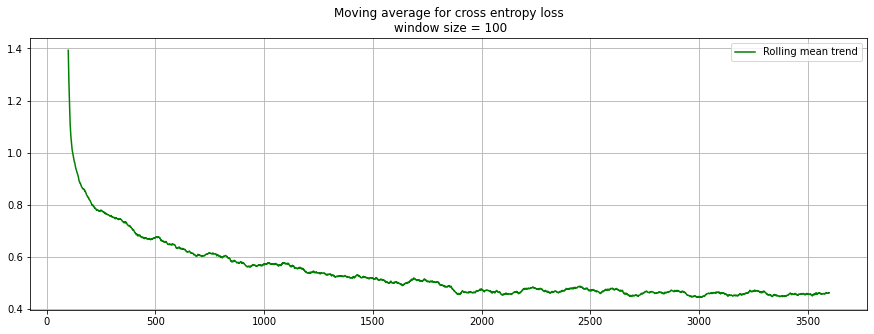

In [ ]:
plot_smoothed_series(pd.Series(loss_list4), "cross entropy loss")

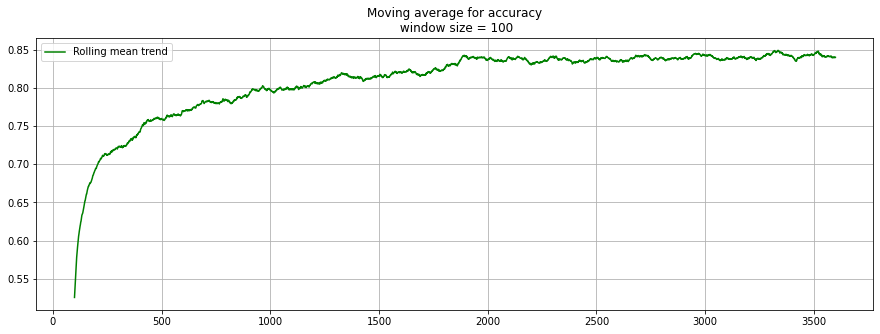

In [ ]:
plot_smoothed_series(pd.Series(acc_list4), "accuracy")

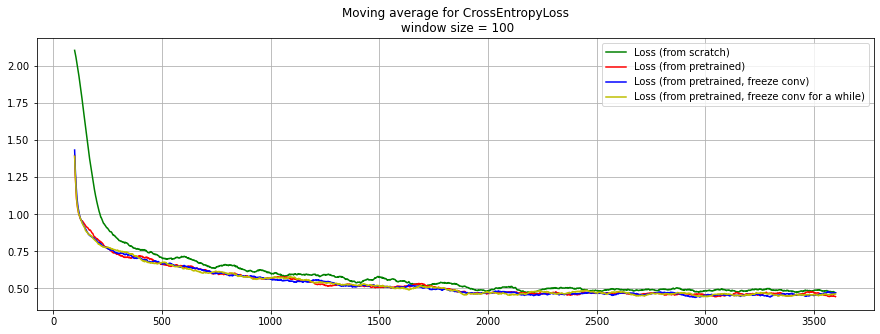

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Moving average for CrossEntropyLoss\n window size = 100")

def draw(series, color, label):
    rolling_mean = series.rolling(window=100).mean()
    plt.plot(rolling_mean, color, label=label)

draw(pd.Series(loss_list), "g", label="Loss (from scratch)")
draw(pd.Series(loss_list2), "r", label="Loss (from pretrained)")
draw(pd.Series(loss_list3), "b", label="Loss (from pretrained, freeze conv)")
draw(pd.Series(loss_list4), "y", label="Loss (from pretrained, freeze conv for a while)")

plt.legend()
plt.grid(True)
plt.show()

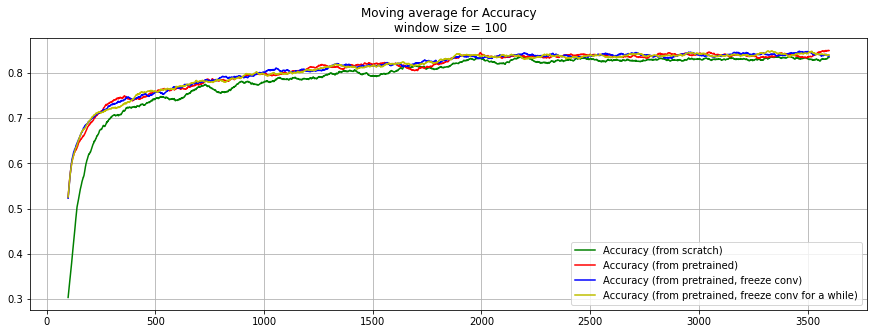

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Moving average for Accuracy\n window size = 100")

def draw(series, color, label):
    rolling_mean = series.rolling(window=100).mean()
    plt.plot(rolling_mean, color, label=label)

draw(pd.Series(acc_list), "g", label="Accuracy (from scratch)")
draw(pd.Series(acc_list2), "r", label="Accuracy (from pretrained)")
draw(pd.Series(acc_list3), "b", label="Accuracy (from pretrained, freeze conv)")
draw(pd.Series(acc_list4), "y", label="Accuracy (from pretrained, freeze conv for a while)")

plt.legend()
plt.grid(True)
plt.show()